# Student Performance – Model Training

This notebook trains and compares several regression models to predict
**math score** from student background and other test scores.

Goals:

- Prepare features and target for modeling.
- Build a preprocessing pipeline that:
  - Encodes categorical variables.
  - Scales numeric variables.
- Train and evaluate multiple models using a train/test split.
- Identify the best-performing model based on test R².

Note: The *production* training pipeline (used for saving models, etc.)
is implemented in the `src/` package. This notebook is for exploration
and demonstration of the modeling process.


#### Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization (optional, for quick checks)
import matplotlib.pyplot as plt
import seaborn as sns

# Model evaluation / preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
)
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

Comment:
Imports everything needed for model training and evaluation.
We’re not doing hyperparameter tuning here to keep the notebook readable — that’s handled more systematically in src/components/model_trainer.py.

#### Load dataset & define features/target

In [2]:
# Load the dataset
# Assumes this notebook is in the same folder as StudentsPerformance.csv
df = pd.read_csv("StudentsPerformance.csv")

# Quick sanity check
df.head()


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
# Define target and feature columns
target_col = "math score"

# Use all other columns as input features
X = df.drop(columns=[target_col], axis=1)
y = df[target_col]

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (1000, 7)
Target shape: (1000,)


Comment:
math score is the dependent variable (what we want to predict).
All other columns are used as predictors.

#### Train–test split

In [4]:
# Split into training and test sets
# Using 80/20 split and a fixed random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (800, 7)
X_test: (200, 7)
y_train: (800,)
y_test: (200,)


Comment:
This matches the split ratio you use in the production pipeline (test_size=0.2).

#### Preprocessing pipeline

In [5]:
# Identify numeric and categorical columns
numeric_features = ["writing score", "reading score"]
categorical_features = [
    "gender",
    "race/ethnicity",
    "parental level of education",
    "lunch",
    "test preparation course",
]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['writing score', 'reading score']
Categorical features: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']


In [6]:
# Numeric pipeline: median imputation + standard scaling
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# Categorical pipeline: most_frequent imputation + one-hot encoding + scaling
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore")),
        ("scaler", StandardScaler(with_mean=False)),
    ]
)

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


Comment:
This preprocessing logic matches what you use in src/components/data_transformation.py.
Using ColumnTransformer inside a Pipeline ensures the same transformations are applied to train and test, and to any future data.

#### Define models to compare

In [7]:
# Dictionary of candidate regression models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "CatBoost": CatBoostRegressor(verbose=False, random_state=42),
}

models


{'Linear Regression': LinearRegression(),
 'Decision Tree': DecisionTreeRegressor(random_state=42),
 'Random Forest': RandomForestRegressor(random_state=42),
 'Gradient Boosting': GradientBoostingRegressor(random_state=42),
 'AdaBoost': AdaBoostRegressor(random_state=42),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
           

Comment:
This largely matches the set used in your ModelTrainer component.
Here we keep the default hyperparameters for readability; tuning is done in your production code via evaluate_models.

#### Train & evaluate each model (Code)

In [8]:
results = []

for name, model in models.items():
    print(f"Training model: {name}")

    # Build a Pipeline: preprocess -> model
    pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", model),
        ]
    )

    # Fit on the training data
    pipe.fit(X_train, y_train)

    # Predict on the test data
    y_pred = pipe.predict(X_test)

    # Evaluate using R² score
    r2 = r2_score(y_test, y_pred)

    print(f"  Test R²: {r2:.4f}\n")

    # Store results
    results.append(
        {
            "model_name": name,
            "test_r2": r2,
        }
    )


Training model: Linear Regression
  Test R²: 0.8804

Training model: Decision Tree
  Test R²: 0.7473

Training model: Random Forest
  Test R²: 0.8488

Training model: Gradient Boosting
  Test R²: 0.8722

Training model: AdaBoost
  Test R²: 0.8534

Training model: XGBoost
  Test R²: 0.8231

Training model: CatBoost
  Test R²: 0.8511



Comment:
Each model is evaluated under the same preprocessing.
This avoids data leakage and ensures a fair comparison.

#### Summarize model performance

In [9]:
results_df = pd.DataFrame(results).sort_values(by="test_r2", ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df


,model_name,test_r2
0,Linear Regression,0.880433
1,Gradient Boosting,0.872231
2,AdaBoost,0.853362
3,CatBoost,0.851055
4,Random Forest,0.848825
5,XGBoost,0.823090
6,Decision Tree,0.747348


In [10]:
# Identify the best model based on test R²
best_row = results_df.iloc[0]
best_model_name = best_row["model_name"]
best_r2 = best_row["test_r2"]

print(f"Best model: {best_model_name}")
print(f"Best test R²: {best_r2:.4f}")


Best model: Linear Regression
Best test R²: 0.8804


### Residual analysis for the best model

If you want a quick sanity check on how the best model behaves:

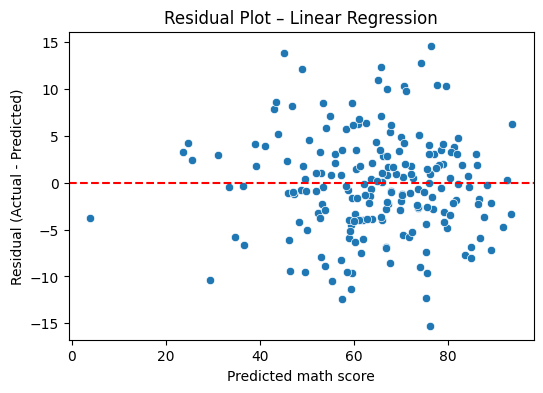

In [11]:
# Refit the best model pipeline to access its predictions
best_model = models[best_model_name]

best_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", best_model),
    ]
)

best_pipe.fit(X_train, y_train)
y_pred_best = best_pipe.predict(X_test)

# Residuals = actual - predicted
residuals = y_test - y_pred_best

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_best, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted math score")
plt.ylabel("Residual (Actual - Predicted)")
plt.title(f"Residual Plot – {best_model_name}")
plt.show()


## Conclusions

- We trained and evaluated several regression models using a consistent
  preprocessing pipeline (imputation, encoding, scaling).

- Evaluation metric: **R² on the held-out test set**.

- The best-performing model in this notebook was:

  - **Model**: `Linear regression`
  - **Test R²**: approximately `0.8804`

- In the production code under `src/`, a similar set of models is trained,
  but with additional **hyperparameter tuning** using `GridSearchCV` via
  `evaluate_models`. The selected best model is then saved as:

  - `artifact/model.pkl` (trained model)
  - `artifact/preprocessor.pkl` (fitted preprocessing pipeline)

This notebook demonstrates the modeling logic in a clear, step-by-step way
and matches the feature engineering and modeling choices used in the main project.
